<a href="https://colab.research.google.com/github/UjalaJha/NasaSpaceAppChallenge/blob/master/Fire_detection_classification/Fire_severity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthpy seaborn geopandas

     |████████████████████████████████| 1.4MB 3.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 972kB 25.8MB/s 
     |████████████████████████████████| 18.1MB 182kB/s 
     |████████████████████████████████| 14.8MB 172kB/s 
     |████████████████████████████████| 10.9MB 39.6MB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp36-none-any.whl size=1365088 sha256=3532d5effd9414077d2d57dea160c5a5cda4169c0022ec7f3bba9bbad4543f1d
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


In [ ]:
pwd

'/content'

In [ ]:
# import requests, zipfile, io
# r = requests.get("https://dds.cr.usgs.gov/download-staging/eyJpZCI6NTk3NjExMCwiY29udGFjdElkIjoxOTYwNzc5fQ==")
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall("/content/drive/My Drive/spaceapps_data/empedrado_2016_2017/sentinel-post-fire")

In [ ]:
from glob import glob
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

import rasterio as rio
from rasterio.plot import plotting_extent, show
from rasterio.plot import reshape_as_raster, reshape_as_image

import geopandas as gpd
from shapely.geometry import mapping, box

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

sns.set_style('white')
sns.set(font_scale=1.5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths
sentinel_pre_fire_bands = glob("drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/*.jp2")

sentinel_post_fire_bands = glob("drive/My Drive/spaceapps_data/australia_2019/sentinel-post-fire/*.jp2")

sentinel_pre_fire_bands.sort()
sentinel_post_fire_bands.sort()

print(sentinel_pre_fire_bands)
print(sentinel_post_fire_bands)

['drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/T56HKJ_20190927T000239_B02.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/T56HKJ_20190927T000239_B03.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/T56HKJ_20190927T000239_B04.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/T56HKJ_20190927T000239_B12.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/T56HKJ_20190927T000239_B8A.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/T56HKJ_20190927T000239_TCI.jp2']
['drive/My Drive/spaceapps_data/australia_2019/sentinel-post-fire/T56HKJ_20191121T000241_B02.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-post-fire/T56HKJ_20191121T000241_B03.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-post-fire/T56HKJ_20191121T000241_B04.jp2', 'drive/My Drive/spaceapps_data/australia_2019/sentinel-post-fire/T56HKJ_20191121T000241_B12.jp2', 'drive/My Drive/spaceapp

In [ ]:
def show_band(img, title='', size=(6,6), cmap='viridis'):
  print(title+' Shape: ', img.shape)
  fig = plt.figure(figsize=size)
  plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap= cmap)
  plt.axis('off')
  plt.colorbar()
  plt.title(title)
  plt.show()

def nbr(band1, band2):
    """
    This function takes an input the arrays of the bands from the read_band_image
    function and returns the Normalized Burn ratio (NBR)
    input:  band1   array (n x m)      array of first band image e.g B8A
            band2   array (n x m)      array of second band image e.g. B12
    output: nbr     array (n x m)      normalized burn ratio
    """
    nbr = (band1 - band2) / (band1 + band2)
    return nbr

def dnbr(nbr1,nbr2):
    """
    This function takes as input the pre- and post-fire NBR and returns the dNBR
    input:  nbr1     array (n x m)       pre-fire NBR
            nbr2     array (n x m)       post-fire NBR
    output: dnbr     array (n x m)       dNBR
    """
    dnbr = nbr1 - nbr2
    return dnbr

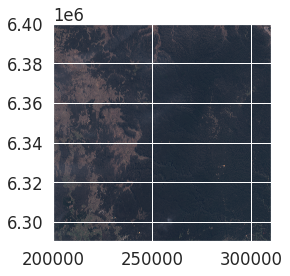

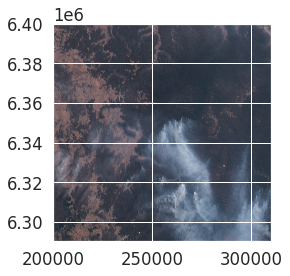

In [ ]:
TCI_pre = rio.open(sentinel_pre_fire_bands[5])
TCI_post = rio.open(sentinel_post_fire_bands[5])

show(TCI_pre.read(), transform=TCI_pre.transform)
show(TCI_post.read(), transform=TCI_post.transform)

In [ ]:
# Read the pre-fire band images
with rio.open(sentinel_pre_fire_bands[3]) as f1:
    SWIR = reshape_as_image(f1.read())

with rio.open(sentinel_pre_fire_bands[4]) as f1:
    NIR = reshape_as_image(f1.read())

# run once, only to generate the RGB composite image.
red = rio.open(sentinel_pre_fire_bands[2])
green = rio.open(sentinel_pre_fire_bands[1])
blue = rio.open(sentinel_pre_fire_bands[0])

# Create an RGB image 
with rio.open('drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/RGB.tiff','w',driver='Gtiff', width=red.width, height=red.height, 
              count=3,crs=red.crs,transform=red.transform, dtype=red.dtypes[0]) as rgb:
    rgb.write(red.read(1),1) 
    rgb.write(green.read(1),2) 
    rgb.write(blue.read(1),3) 
    rgb.close()

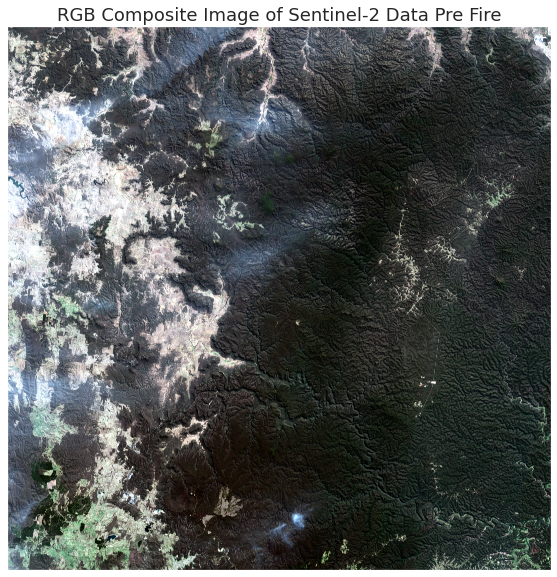

In [ ]:
with rio.open('drive/My Drive/spaceapps_data/australia_2019/sentinel-pre-fire/RGB.tiff') as rgb_f:
  data = rgb_f.read()

ep.plot_rgb(data, rgb=(0,1,2), stretch=True, title='RGB Composite Image of Sentinel-2 Data Pre Fire')

NIR Band Shape:  (5490, 5490, 1)


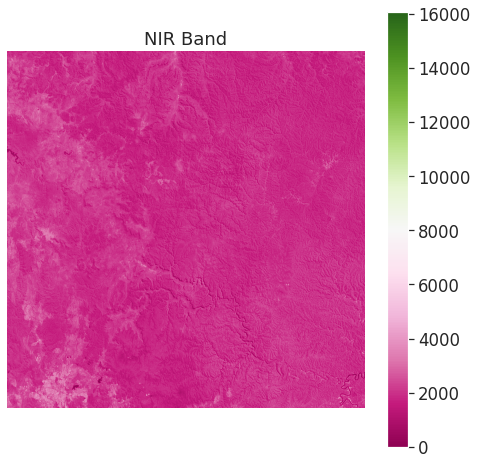

In [ ]:
show_band(NIR, title='NIR Band', size = (8, 8), cmap='PiYG')

SWIR Band Shape:  (5490, 5490, 1)


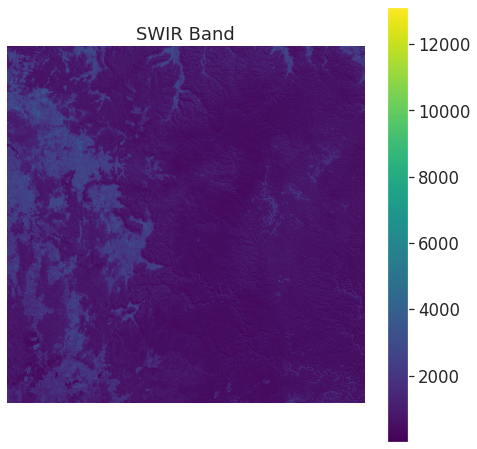

In [ ]:
show_band(SWIR, title='SWIR Band', size = (8, 8))

In [ ]:
# Calculation of pre-fire NBR
pre_fire_nbr = nbr(NIR.astype(int), SWIR.astype(int))

pre_fire_nbr Shape:  (5490, 5490, 1)


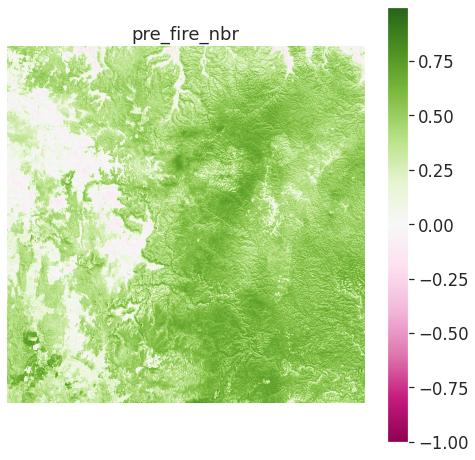

In [ ]:
show_band(pre_fire_nbr, title='pre_fire_nbr', size=(8, 8), cmap='PiYG')

In [ ]:
# Read the post-fire band images
with rio.open(sentinel_post_fire_bands[3]) as f1:
    SWIR = reshape_as_image(f1.read())

with rio.open(sentinel_post_fire_bands[4]) as f1:
    NIR = reshape_as_image(f1.read())

# run once, only to generate the RGB composite image.
red = rio.open(sentinel_post_fire_bands[2])
green = rio.open(sentinel_post_fire_bands[1])
blue = rio.open(sentinel_post_fire_bands[0])

# Create an RGB image 
with rio.open('drive/My Drive/spaceapps_data/australia_2019/sentinel-post-fire/RGB.tiff','w',driver='Gtiff', width=red.width, height=red.height, 
              count=3,crs=red.crs,transform=red.transform, dtype=red.dtypes[0]) as rgb:
    rgb.write(red.read(1),1) 
    rgb.write(green.read(1),2) 
    rgb.write(blue.read(1),3) 
    rgb.close()

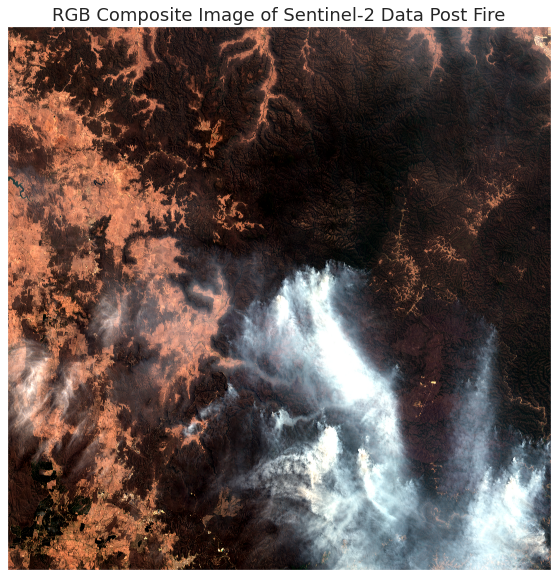

In [ ]:
with rio.open('drive/My Drive/spaceapps_data/australia_2019/sentinel-post-fire/RGB.tiff') as rgb_f:
  data = rgb_f.read()

ep.plot_rgb(data, rgb=(0,1,2), stretch=True, title='RGB Composite Image of Sentinel-2 Data Post Fire')

plt.show()

NIR Band Shape:  (5490, 5490, 1)


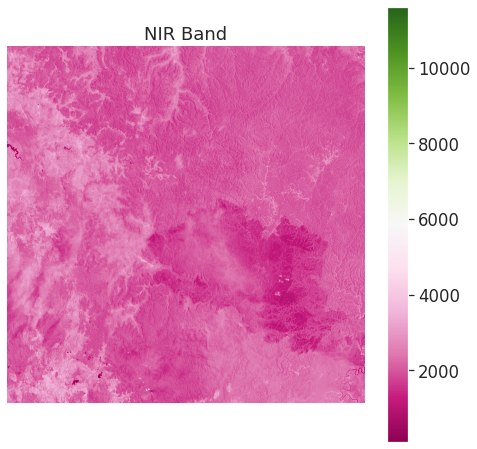

In [ ]:
show_band(NIR, title='NIR Band', size = (8, 8), cmap='PiYG')

SWIR Band Shape:  (5490, 5490, 1)


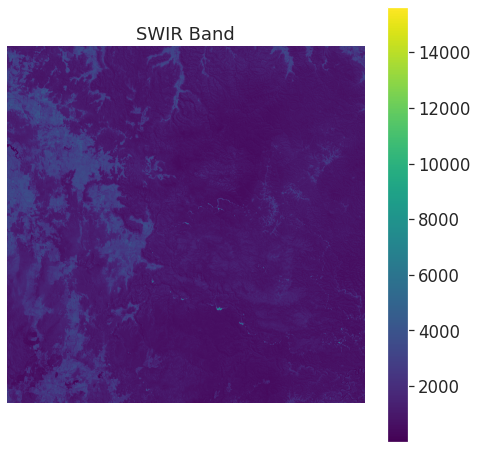

In [ ]:
show_band(SWIR, title='SWIR Band', size = (8, 8))

In [ ]:
# Calculation of post-fire NBR
post_fire_nbr = nbr(NIR.astype(int), SWIR.astype(int))

post_fire_nbr Shape:  (5490, 5490, 1)


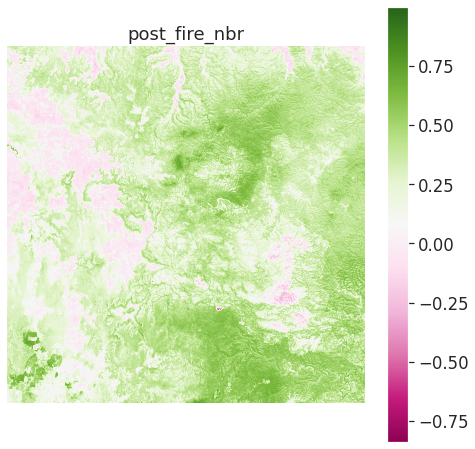

In [ ]:
show_band(post_fire_nbr, title='post_fire_nbr', size=(8, 8), cmap='PiYG')

In [ ]:
# Calculation of dNBR
DNBR = dnbr(pre_fire_nbr, post_fire_nbr)

In [ ]:
# Define bins that you want, and then classify the data
dnbr_class_bins = [-np.inf, -0.1, 0.1, 0.27, 0.66, np.inf]
dnbr_sentinel_class = np.digitize(DNBR, dnbr_class_bins)

print(np.unique(dnbr_sentinel_class))

[1 2 3 4 5]


In [ ]:
dnbr_sentinel_class.shape

(5490, 5490, 1)

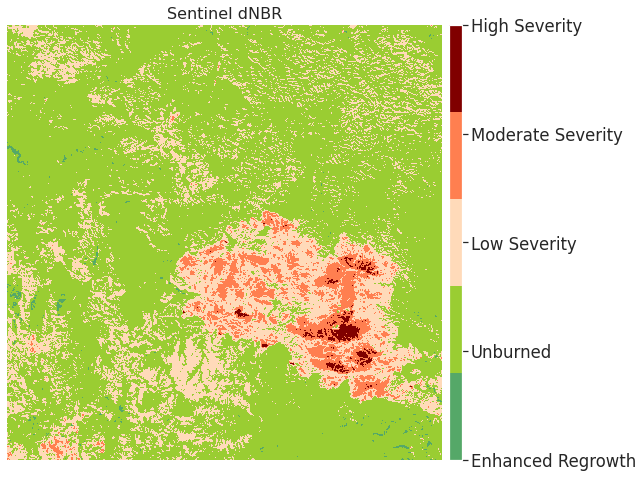

In [ ]:
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"]

nbr_colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]

nbr_cmap = ListedColormap(nbr_colors)

# Plot the data with a custom legend
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(dnbr_sentinel_class.reshape(dnbr_sentinel_class.shape[:2]), cmap=nbr_cmap)

ax.set_title("Sentinel dNBR",
             fontsize=16)

cbar = ep.colorbar(im)

cbar.set_ticks(np.unique(dnbr_sentinel_class))
cbar.set_ticklabels(dnbr_cat_names)

# Turn off ticks
ax.set_axis_off()
plt.show()

In [ ]:
with rio.open('drive/My Drive/spaceapps_data/australia_2019/australia_final.tiff', 'w', driver='GTiff', dtype=rio.float32, width= 5490 , height = 5490, count=1) as gt:
     gt.write(dnbr_sentinel_class.reshape(1, 5490, 5490).astype(rio.float32))

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:235: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


In [ ]:
# To calculate area, multiply the number of pixels in each bin by image resolution

sentinel_pixel_size = 20 * 20
enhanced_regrowth = (dnbr_sentinel_class[dnbr_sentinel_class == 1]).size
unburned = (dnbr_sentinel_class[dnbr_sentinel_class == 2]).size
low = (dnbr_sentinel_class[dnbr_sentinel_class == 3]).size
moderate = (dnbr_sentinel_class[dnbr_sentinel_class == 4]).size
high = (dnbr_sentinel_class[dnbr_sentinel_class == 5]).size


enhanced_regrowth = np.multiply(enhanced_regrowth, sentinel_pixel_size)/1000000
unburned = np.multiply(unburned, sentinel_pixel_size)/1000000
low = np.multiply(low, sentinel_pixel_size)/1000000
moderate = np.multiply(moderate, sentinel_pixel_size)/1000000
high = np.multiply(high, sentinel_pixel_size)/1000000

print("Enhanced Regrowth Area:", enhanced_regrowth, "sq km")
print("Unburned Area:", unburned, "sq km")
print("Low Severity Burn Area:", low, "sq km")
print("Moderate Severity Burn Area:", moderate, "sq km")
print("High Severity Burn Area:", high, "sq km")

Enhanced Regrowth Area: 57.6468 sq km
Unburned Area: 7033.6148 sq km
Low Severity Burn Area: 4267.76 sq km
Moderate Severity Burn Area: 646.3844 sq km
High Severity Burn Area: 50.634 sq km
